In [6]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [7]:
import os, os.path
import re
import glob
import pickle
import numpy
from tqdm import tqdm
from scipy.special import logsumexp
from scipy import interpolate

from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.actionAngle import actionAngleTorus
from galpy.orbit import Orbit
from galpy.df import streamdf
from galpy.util import bovy_plot, bovy_conversion, bovy_coords, save_pickles

import seaborn as sns
%pylab inline
from matplotlib import cm, gridspec 
from matplotlib.ticker import NullFormatter
import copy
import corner
save_figures= False


import sys; sys.path.insert(0, '../')
from src import MWPotential2014Likelihood
from src import pal5_util
from src import mcmc_pal5
_REFR0, _REFV0= MWPotential2014Likelihood._REFR0, MWPotential2014Likelihood._REFV0
ro, vo= _REFR0, _REFV0

Populating the interactive namespace from numpy and matplotlib


In [8]:
from matplotlib.cbook import MatplotlibDeprecationWarning
import warnings
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

# Exploration of the Milky Way's dark halo shape using the Palomar 5 stream

## The data

In [4]:
pos_radec, rvel_ra= pal5_util.pal5_data_2016()

## Some convenience functions

In [5]:
width_trailing= pal5_util.width_trailing

In [6]:
def plot_data_add_labels(radeconly=False,rvonly=False,color=sns.color_palette()[2],
                        p1=(1,2,1),p2=(1,2,2),
                        noxlabel_dec=False,noxlabel_vlos=False,noylabel=False):
    if noxlabel_dec or noylabel: nullfmt= NullFormatter()
    if not radeconly and not rvonly: subplot(*p1)
    if not rvonly:
        if not noxlabel_dec: xlabel(r'$\mathrm{RA}\,(\mathrm{degree})$')
        else: gca().xaxis.set_major_formatter(nullfmt)
        if not noylabel: ylabel(r'$\mathrm{Dec}\,(\mathrm{degree})$')
        else: gca().yaxis.set_major_formatter(nullfmt)
        xlim(250.,221.)
        ylim(-5.,9.)
        bovy_plot._add_ticks()
        errorbar(pos_radec[:,0],pos_radec[:,1],yerr=pos_radec[:,2],
                 ls='none',marker='o',color=color)
    if radeconly: return None
    if not rvonly: subplot(*p2)
    if not noxlabel_vlos: xlabel(r'$\mathrm{RA}\,(\mathrm{degree})$')
    else: gca().xaxis.set_major_formatter(nullfmt)    
    if not noylabel: ylabel(r'$V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$')
    else: gca().yaxis.set_major_formatter(nullfmt)
    xlim(250.,221.)
    ylim(-80.,0.)
    bovy_plot._add_ticks()
    errorbar(rvel_ra[rvel_ra[:,0] > 230.5,0],rvel_ra[rvel_ra[:,0] > 230.5,1],
             yerr=rvel_ra[rvel_ra[:,0] > 230.5,2],
             ls='none',marker='o',color=color)
    return None
def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025,0.78])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

## A fiducial model

The fiducial model assumes a spherical halo, with the best-fit parameters from fitting to the MWPotential2014 data

In [7]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
ro,vo= _REFR0,_REFV0
pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
            solarmotion=[-11.1,24.,7.25])
aAI= actionAngleIsochroneApprox(pot=pot,b=0.8)
sigv= 0.2

In [8]:
try:
    with open('sdf_trailing.pkl', 'rb') as file:
        sdf_trailing = pickle.load(file)
except Exception:
    sdf_trailing= streamdf(sigv/vo,progenitor=prog,
                           pot=pot,aA=aAI,
                           leading=False,nTrackChunks=11,
                           tdisrupt=10./bovy_conversion.time_in_Gyr(vo,ro),
                           ro=ro,vo=vo,R0=ro,
                           vsun=[-11.1,vo+24.,7.25],
                           custom_transform=pal5_util._TPAL5)
    with open('sdf_trailing.pkl', 'wb') as file:
        pickle.dump(sdf_trailing, file)
try:
    with open('sdf_leading.pkl', 'rb') as file:
        sdf_leading = pickle.load(file)
except Exception:
    sdf_leading= streamdf(sigv/vo,progenitor=prog,
                          pot=pot,aA=aAI,
                          leading=True,nTrackChunks=11,
                          tdisrupt=10./bovy_conversion.time_in_Gyr(vo,ro),
                          ro=ro,vo=vo,R0=ro,
                          vsun=[-11.1,vo+24.,7.25],
                          custom_transform=pal5_util._TPAL5)
    with open('sdf_leading.pkl', 'wb') as file:
        pickle.dump(sdf_leading, file)

In [9]:
threshold= 0.3
print("Angular length: %f deg (leading,trailing)=(%f,%f) deg" % \
    (sdf_leading.length(ang=True,coord='customra',threshold=threshold)\
    +sdf_trailing.length(ang=True,coord='customra',threshold=threshold),
     sdf_leading.length(ang=True,coord='customra',threshold=threshold),
     sdf_trailing.length(ang=True,coord='customra',threshold=threshold)))
print("Angular width (FWHM): %f arcmin" % (width_trailing(sdf_trailing)))
print("Velocity dispersion: %f km/s" % (pal5_util.vdisp_trailing(sdf_trailing)))

Angular length: 71.345983 deg (leading,trailing)=(44.107359,27.238624) deg
Angular width (FWHM): 14.526620 arcmin
Velocity dispersion: 0.825234 km/s


In [10]:
trackRADec_trailing=\
  bovy_coords.lb_to_radec(sdf_trailing._interpolatedObsTrackLB[:,0],
                          sdf_trailing._interpolatedObsTrackLB[:,1],
                          degree=True)
trackRADec_leading=\
  bovy_coords.lb_to_radec(sdf_leading._interpolatedObsTrackLB[:,0],
                          sdf_leading._interpolatedObsTrackLB[:,1],
                          degree=True)
lb_sample_trailing= sdf_trailing.sample(n=10000,lb=True)
lb_sample_leading= sdf_leading.sample(n=10000,lb=True)
radec_sample_trailing= bovy_coords.lb_to_radec(lb_sample_trailing[0],
                                               lb_sample_trailing[1],
                                               degree=True)
radec_sample_leading= bovy_coords.lb_to_radec(lb_sample_leading[0],
                                              lb_sample_leading[1],
                                              degree=True)

<ErrorbarContainer object of 3 artists>

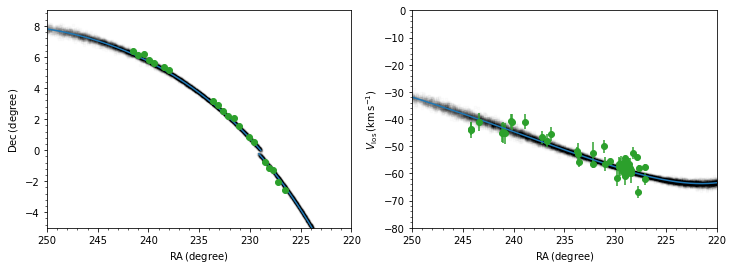

In [11]:
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    trackRADec_trailing[:,1],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-5.,9.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$\mathrm{Dec}\,(\mathrm{degree})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    trackRADec_leading[:,1],
                    color=sns.color_palette()[0],
                    overplot=True)
plot(radec_sample_trailing[:,0],radec_sample_trailing[:,1],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],radec_sample_leading[:,1],'k.',
     alpha=0.01,zorder=0)
errorbar(pos_radec[:,0],pos_radec[:,1],yerr=pos_radec[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])
subplot(1,2,2)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    sdf_trailing._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-80.,0.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    sdf_leading._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    overplot=True)
plot(radec_sample_trailing[:,0],lb_sample_trailing[3],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],lb_sample_leading[3],'k.',
     alpha=0.01,zorder=0)
errorbar(rvel_ra[:,0],rvel_ra[:,1],yerr=rvel_ra[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])

## The orbit of Pal 5 in different flattened and triaxial potentials

In [12]:
bf_savefilename= 'mwpot14varyc-bf.pkl'
if os.path.exists(bf_savefilename):
    with open(bf_savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        bf_params= pickle.load(savefile)
else:
    print(IOError("Need to calculate best-fit potentials for different c in MWPotential2014-varyc.ipynb first"))
bf_params= numpy.array(bf_params)
bf_params= bf_params[cs <= 3.]
cs= cs[cs <= 3.]

In [13]:
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
for bp,c in zip(bf_params,cs):
    pot= MWPotential2014Likelihood.setup_potential(bp,c,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog.flip(inplace=True)
    progfs.append(prog)

Vary $c$ along the best-fit line:

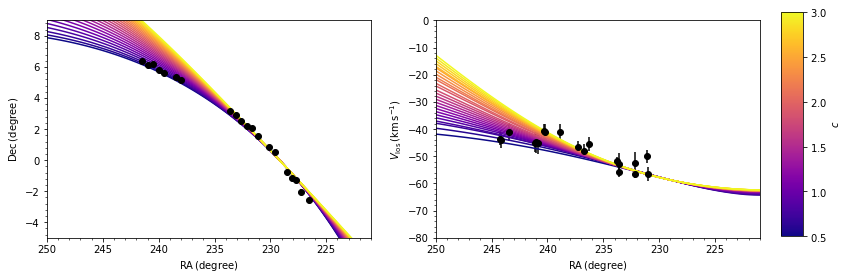

In [14]:
figsize(12,4)
cmap= cm.plasma
for c,orb,orbf in zip(cs,progs,progfs):
    tc= cmap((c-0.5)/2.5)
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(0.5,3.,r'$c$',save_figures=False)

Vary $b$ for $c=1$ (pa=0):

In [15]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
bs= numpy.arange(0.5,2.1,0.1)
for b in bs:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo,b=b)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog.flip(inplace=True)
    progfs.append(prog)

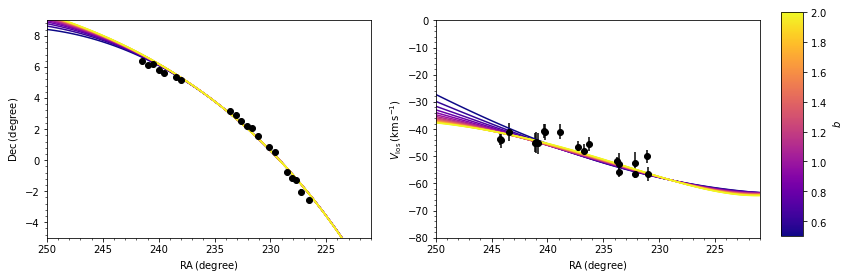

In [16]:
figsize(12,4)
cmap= cm.plasma
for b,orb,orbf in zip(bs,progs,progfs):
    tc= cmap((b-0.5)/1.5)
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(0.5,2.,r'$b$',save_figures=False)

Vary $b$ for $c=1$ (pa=45 degree):

In [17]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
bs= numpy.arange(0.5,2.1,0.1)
for b in bs:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo,b=b,pa=numpy.pi/4.)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog.flip(inplace=True)
    progfs.append(prog)

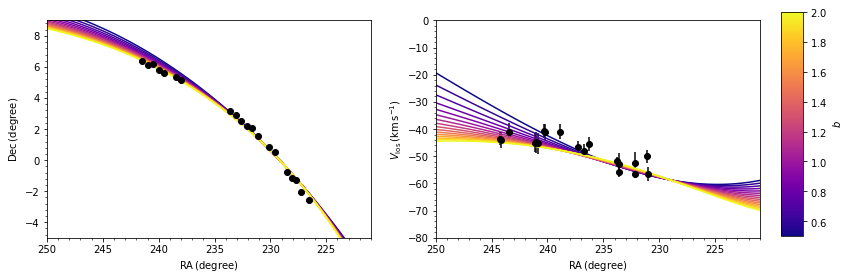

In [18]:
figsize(12,4)
cmap= cm.plasma
for b,orb,orbf in zip(bs,progs,progfs):
    tc= cmap((b-0.5)/1.5)
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(0.5,2.,r'$b$',save_figures=False)

The Pal 5 stream is not very sensitive to changes in $b$. Vary the distance:

In [19]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
ds= numpy.linspace(22.5,24.5,101)
for d in ds:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,d,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,d,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog.flip(inplace=True)
    progfs.append(prog)

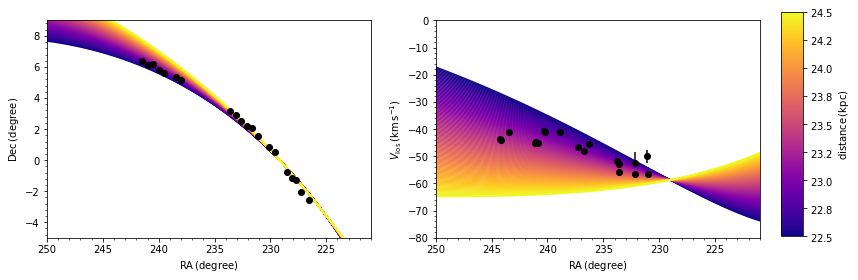

In [20]:
figsize(12,4)
cmap= cm.plasma
for d,orb,orbf in zip(ds,progs,progfs):
    tc= cmap((d-numpy.amin(ds))/(numpy.amax(ds)-numpy.amin(ds)))
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(numpy.amin(ds),numpy.amax(ds),r'$\mathrm{distance}\,(\mathrm{kpc})$',save_figures=False)

Vary the proper motion parallel to the stream:

In [22]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,2.5,101)
pms= numpy.linspace(-0.3,0.3,101)
for pm in pms:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257+2.257/2.296*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257+2.257/2.296*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
#     prog._orb.orbit[:,1]*= -1.
#     prog.orbit[:,1]*= -1.
#     prog.orbit[:,2]*= -1.
#     prog.orbit[:,4]*= -1.
    prog.flip(inplace=True)
    progfs.append(prog)

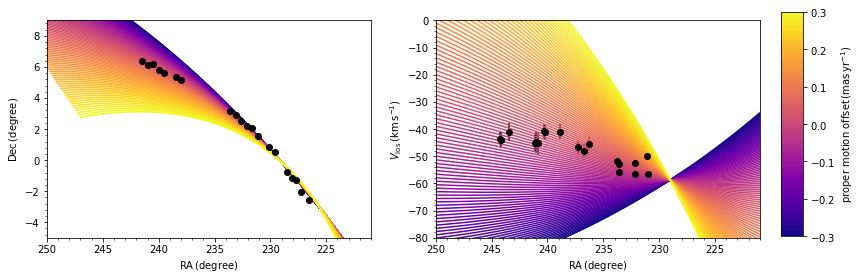

In [23]:
figsize(12,4)
cmap= cm.plasma
for pm,orb,orbf in zip(pms,progs,progfs):
    tc= cmap((pm-numpy.amin(pms))/(numpy.amax(pms)-numpy.amin(pms)))
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(numpy.amin(pms),numpy.amax(pms),r'$\mathrm{proper\ motion\ offset}\,(\mathrm{mas\,yr}^{-1})$',
             save_figures=False)

Vary the proper motion perpendicular to the stream:

In [24]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,2.5,101)
pms= numpy.linspace(-0.3,0.3,101)
for pm in pms:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257-2.296/2.257*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257-2.296/2.257*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog.flip(inplace=True)
    progfs.append(prog)

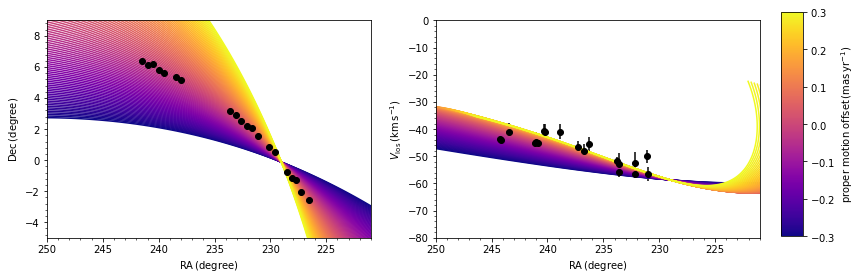

In [25]:
figsize(12,4)
cmap= cm.plasma
for pm,orb,orbf in zip(pms,progs,progfs):
    tc= cmap((pm-numpy.amin(pms))/(numpy.amax(pms)-numpy.amin(pms)))
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(numpy.amin(pms),numpy.amax(pms),r'$\mathrm{proper\ motion\ offset}\,(\mathrm{mas\,yr}^{-1})$',
             save_figures=False)

## How does the track, width, and length of the Pal 5 stream vary with the potential and the uncertain phase-space location of the Pal 5 cluster?

### Varying the flattening $c$ of the halo

We compute the stream structure for a fiducial set of parameters, to get a sense of where the track lies and how the width and length vary

In [26]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

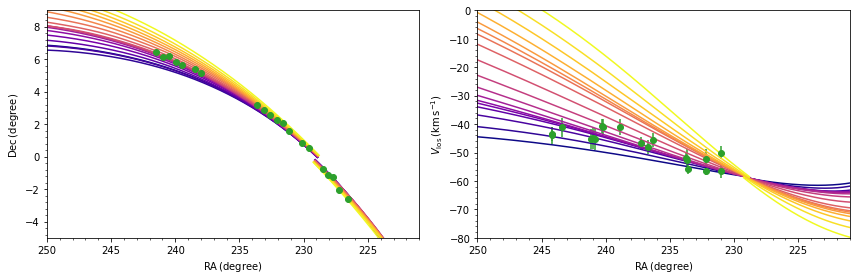

In [27]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
tight_layout()

### Varying the circular velocity $V_c(R_0)$ to change the normalization of the potential

In [28]:
savefilename= 'mwpot14-pal5-varyvc.pkl'

p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        vcs= pickle.load(savefile)
        pal5varyvc= pickle.load(savefile)
else:
    vcs= numpy.arange(200.,255.,5.)
    pal5varyvc= numpy.zeros((len(vcs),4,pal5varyc[0].shape[1],pal5varyc[0].shape[2]))
    for ii,vc in enumerate(vcs):
        t= pal5_util.predict_pal5obs(p_b15,1.,multi=8,vo=vc,singlec=True,useTM=False)
        for jj in range(4):
            pal5varyvc[ii,jj]= t[jj][0]
    save_pickles(savefilename,vcs,pal5varyvc)

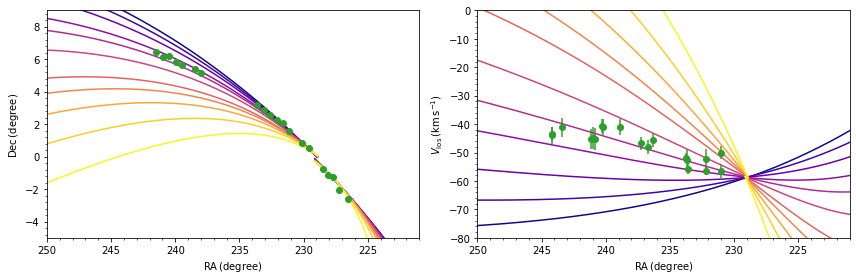

In [29]:
figsize(12,4)
cmap= cm.plasma
for ii, vc in enumerate(vcs):
    tc= cmap((vc-numpy.amin(vcs))/(numpy.amax(vcs)-numpy.amin(vcs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyvc[ii,0,:,0],pal5varyvc[ii,0,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyvc[ii,1,:,0],pal5varyvc[ii,1,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyvc[ii,2,:,0],pal5varyvc[ii,2,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyvc[ii,3,:500,0],pal5varyvc[ii,3,:500,1],
                        color=tc,overplot=True)
plot_data_add_labels()
tight_layout()

### Varying the distance to the Pal 5 cluster

In [31]:
savefilename= 'mwpot14-pal5-varyd.pkl'

p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]

if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        ds= pickle.load(savefile)
        pal5varyd= pickle.load(savefile)
else:
    ds= numpy.arange(20.,24.5,0.5)
    pal5varyd= numpy.zeros((len(ds),4,pal5varyc[0].shape[1],pal5varyc[0].shape[2]))
    for ii,d in enumerate(tqdm(ds)):
        t= pal5_util.predict_pal5obs(p_b15,1.,multi=8,dist=d,singlec=True,useTM=False)
        for jj in range(4):
            pal5varyd[ii,jj]= t[jj][0]
    save_pickles(savefilename,ds,pal5varyd)

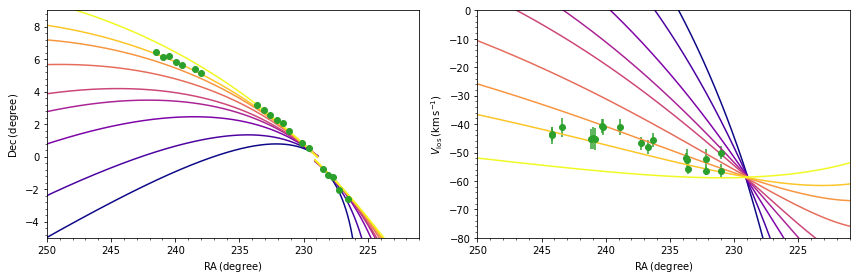

In [32]:
figsize(12,4)
cmap= cm.plasma
for ii, d in enumerate(ds):
    tc= cmap((d-numpy.amin(ds))/(numpy.amax(ds)-numpy.amin(ds)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyd[ii,0,:,0],pal5varyd[ii,0,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyd[ii,1,:,0],pal5varyd[ii,1,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyd[ii,2,:,0],pal5varyd[ii,2,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyd[ii,3,:500,0],pal5varyd[ii,3,:500,1],
                        color=tc,overplot=True)
plot_data_add_labels()
tight_layout()

### Varying the proper motion of the Pal 5 cluster

In [34]:
savefilename= 'mwpot14-pal5-varypm.pkl'


p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]

if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        pms= pickle.load(savefile)
        pal5varypm= pickle.load(savefile)
else:
    pms= numpy.arange(-0.3,0.35,0.05)
    pal5varypm= numpy.zeros((len(pms),4,pal5varyc[0].shape[1],pal5varyc[0].shape[2]))
    for ii,pm in enumerate(tqdm(pms)):
        pmra, pmdec= -2.296+pm,-2.257+2.257/2.296*pm
        t= pal5_util.predict_pal5obs(p_b15,1.,multi=8,pmra=pmra,pmdec=pmdec,
                                     singlec=True,useTM=False)
        for jj in range(4):
            pal5varypm[ii,jj]= t[jj][0]
    save_pickles(savefilename,pms,pal5varypm)

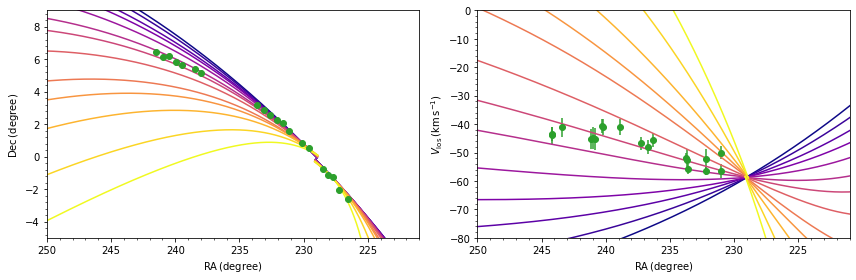

In [35]:
figsize(12,4)
cmap= cm.plasma
for ii, pm in enumerate(pms):
    tc= cmap((pm-numpy.amin(pms))/(numpy.amax(pms)-numpy.amin(pms)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varypm[ii,0,:,0],pal5varypm[ii,0,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varypm[ii,1,:,0],pal5varypm[ii,1,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varypm[ii,2,:,0],pal5varypm[ii,2,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varypm[ii,3,:500,0],pal5varypm[ii,3,:500,1],
                        color=tc,overplot=True)
plot_data_add_labels()
tight_layout()

### All in one plot

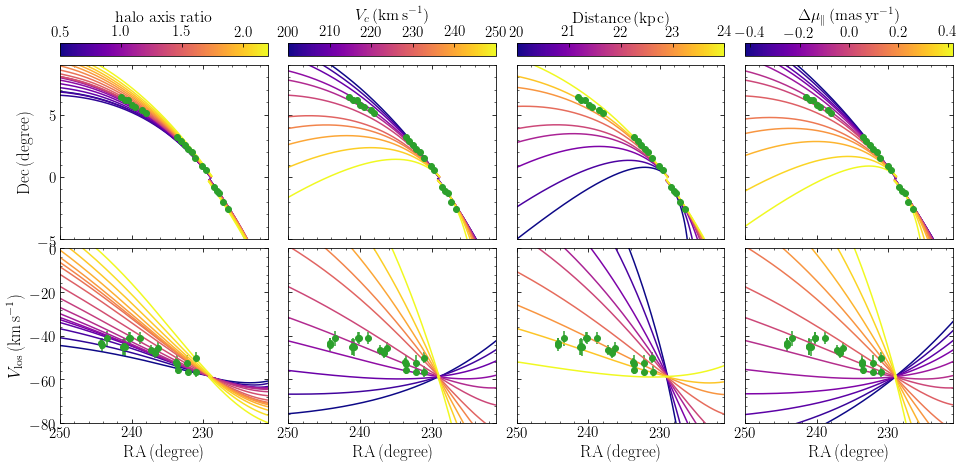

In [36]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(16,7)
cmap= cm.plasma
gs= gridspec.GridSpec(3,4,wspace=0.1,hspace=0.075,height_ratios=[0.075,1.,1.])
# c
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(gs[4])
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(gs[8])
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels(p1=(gs[4],),p2=(gs[8],),noxlabel_dec=True)
# Vc
for ii, vc in enumerate(vcs):
    tc= cmap((vc-numpy.amin(vcs))/(numpy.amax(vcs)-numpy.amin(vcs)))
    subplot(gs[5])
    bovy_plot.bovy_plot(pal5varyvc[ii,0,:,0],pal5varyvc[ii,0,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyvc[ii,1,:,0],pal5varyvc[ii,1,:,1],
                        color=tc,overplot=True)
    subplot(gs[9])
    bovy_plot.bovy_plot(pal5varyvc[ii,2,:,0],pal5varyvc[ii,2,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyvc[ii,3,:500,0],pal5varyvc[ii,3,:500,1],
                        color=tc,overplot=True)
plot_data_add_labels(p1=(gs[5],),p2=(gs[9],),noylabel=True,noxlabel_dec=True)
# D
for ii, d in enumerate(ds):
    tc= cmap((d-numpy.amin(ds))/(numpy.amax(ds)-numpy.amin(ds)))
    subplot(gs[6])
    bovy_plot.bovy_plot(pal5varyd[ii,0,:,0],pal5varyd[ii,0,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyd[ii,1,:,0],pal5varyd[ii,1,:,1],
                        color=tc,overplot=True)
    subplot(gs[10])
    bovy_plot.bovy_plot(pal5varyd[ii,2,:,0],pal5varyd[ii,2,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyd[ii,3,:500,0],pal5varyd[ii,3,:500,1],
                        color=tc,overplot=True)
plot_data_add_labels(p1=(gs[6],),p2=(gs[10],),noylabel=True,noxlabel_dec=True)
#PM
for ii, pm in enumerate(pms):
    tc= cmap((pm-numpy.amin(pms))/(numpy.amax(pms)-numpy.amin(pms)))
    subplot(gs[7])
    bovy_plot.bovy_plot(pal5varypm[ii,0,:,0],pal5varypm[ii,0,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varypm[ii,1,:,0],pal5varypm[ii,1,:,1],
                        color=tc,overplot=True)
    subplot(gs[11])
    bovy_plot.bovy_plot(pal5varypm[ii,2,:,0],pal5varypm[ii,2,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varypm[ii,3,:500,0],pal5varypm[ii,3,:500,1],
                        color=tc,overplot=True)
plot_data_add_labels(p1=(gs[7],),p2=(gs[11],),noylabel=True,noxlabel_dec=True)
# Colorbars
for ii,(label,vals,ticks) in enumerate(zip(\
        [r'$\mathrm{halo\ axis\ ratio}$',r'$V_c\,(\mathrm{km\,s}^{-1})$',r'$\mathrm{Distance}\,(\mathrm{kpc})$',
         r'$\Delta\mu_{\parallel}\,(\mathrm{mas\,yr}^{-1})$'],
        [cs,vcs,ds,pms*numpy.sqrt(1.+(2.257/2.296)**2.)],
        [[0.5,1.,1.5,2.],[200.,210.,220.,230.,240.,250.],
        [20.,21,22,23,24],[-0.4,-0.2,0.,0.2,0.4]])):
    subplot(gs[ii])
    sm= pyplot.cm.ScalarMappable(cmap=cmap,
                                 norm=pyplot.Normalize(vmin=numpy.amin(vals),vmax=numpy.amax(vals)))
    sm._A = []
    CB1= pyplot.colorbar(sm,orientation='horizontal',cax=gca(),ticks=ticks)
    CB1.set_label(label,fontsize=16.)
    CB1.ax.xaxis.set_ticks_position('top')
    CB1.ax.xaxis.set_label_position('top')
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-mwhalo-shape','pal5track.pdf'),
                bbox_inches='tight')

# MCMC results

## The convergence of different walkers for each potential:

In [10]:
def determine_nburn(filename='../pal5_mcmc/mwpot14-fitsigma-0.dat',
                    threshold=0.1,skip=50,
                    return_nsamples=False):
    """Function to detemrine an appropriate nburn for a given chain"""
    # Load the data
    data= numpy.loadtxt(filename,comments='#',delimiter=',')
    lndata= numpy.reshape(data[:,-1],(len(data[:,5])//nwalkers,nwalkers))
    # Perform a running diff wrt skip less
    diff= (lndata-numpy.roll(lndata,skip,axis=0))
    diff[:skip]= -100. # Make sure it's not within the first hundred
    maxln= numpy.nanmax(lndata)
    try:
        indx= (numpy.fabs(numpy.median(diff,axis=1)) < threshold)\
                       *((maxln-numpy.nanmax(lndata,axis=1)) < 1.25)
        if maxln > -22.5:
            indx*= numpy.std(lndata,axis=1) < 3.
        if return_nsamples:
            return len(data)-numpy.arange(len(lndata))[indx][0]*nwalkers
        else:
            return numpy.arange(len(lndata))[indx][0]*nwalkers
    except IndexError:
        if return_nsamples: return 100.
        else: return numpy.prod(lndata.shape)-100


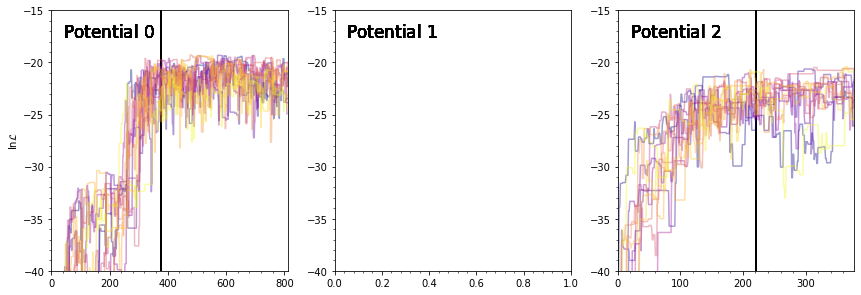

In [38]:
npot= 32
nwalkers= 12
nrow= int(numpy.ceil(npot/4.))
figsize(16,nrow*4)
cmap= cm.plasma

for en,ii in enumerate(range(npot - npot + 3)):
    fn= '../data/pal5_mcmc/mwpot14-fitsigma-%i.dat' % ii
    data= numpy.loadtxt(fn,comments='#',delimiter=',')
    subplot(nrow,4,en+1)
    sdata= numpy.reshape(data[:,-1],(len(data[:,5])//nwalkers,nwalkers))
    for jj in range(nwalkers):
        if ii%4 == 0 and jj == 0:
            tylabel=r'$\ln \mathcal{L}$'
        else:
            tylabel= None
        if ii//4 == nrow-1 and jj == 0:
            txlabel= r'$\#\ \mathrm{of\ steps}$'
        else:
            txlabel= None
        bovy_plot.bovy_plot(list(range(len(sdata[:,jj]))),sdata[:,jj],
                            '-',alpha=0.4,
                            color=cmap(jj/11.),
                            yrange=[-40.,-15.],
                            ylabel=tylabel,xlabel=txlabel,
                            gcf=True)
        bovy_plot.bovy_text(r'$\mathrm{Potential}\ %i$' % ii,size=17.,
                            top_left=True)
    nburn= determine_nburn(fn)//nwalkers
    pyplot.axvline(nburn,lw=2.,zorder=1,color='k')
tight_layout()


### 

In [ ]:
figsize(16,4)
try:
    old_nsamps= copy.deepcopy(nsamps)
except NameError:
    nsamps= numpy.zeros(npot)
    old_nsamps= numpy.zeros(npot)
for en,ii in enumerate(range(npot)):
    fn= '../pal5_mcmc/mwpot14-fitsigma-%i.dat' % ii
    nsamps[en]= determine_nburn(fn,return_nsamples=True)
bovy_plot.bovy_plot(numpy.arange(npot),nsamps,
                   'o',
                    xrange=[-2.,33.],
                    yrange=[0.,7000.],
                    xlabel=r'$\mathrm{Potential}$',
                    ylabel=r'$\#\ \mathrm{of\ samples\ after\ burn-in}$')
bovy_plot.bovy_plot(numpy.arange(npot),old_nsamps,
                   'o',overplot=True)
axhline(4000.,color=sns.color_palette()[2],zorder=0)

In [ ]:
for ii in range(32):
    if determine_nburn('../pal5_mcmc/mwpot14-fitsigma-%i.dat' % ii,return_nsamples=True) > 4000: continue
    print ii, determine_nburn('../pal5_mcmc/mwpot14-fitsigma-%i.dat' % ii,return_nsamples=True)

## Resulting PDFs

In [ ]:
# Read the necessary data for MWPotential2014Likelihood
reload(MWPotential2014Likelihood)
#First read the surface densities
surffile= '../data/mwpot14data/bovyrix13kzdata.csv'
if not surffile is None and os.path.exists(surffile):
    surf= numpy.loadtxt(surffile,delimiter=',')
    surfrs= surf[:,2]
    kzs= surf[:,6]
    kzerrs= surf[:,7]*1000.
# Then the terminal velocities
cl_glon, cl_vterm, cl_corr= MWPotential2014Likelihood.readClemens(dsinl=0.125)
mc_glon, mc_vterm, mc_corr= MWPotential2014Likelihood.readMcClureGriffiths(dsinl=0.125)
termdata= (cl_glon,cl_vterm,cl_corr,
           mc_glon,mc_vterm,mc_corr)
def evi_harmonic(x):
    # Simple harmonic mean estimator of the evidence, bad!!
    return 1./numpy.mean(numpy.exp(-x[:,-1]))
def evi_laplace(x):
    # Laplace estimator of the evidence
    mindx= numpy.argmax(x[:,-1])
    C= numpy.cov(x[:,:6],rowvar=False)
    return numpy.exp(x[mindx,-1])/numpy.sqrt(numpy.linalg.det(C))
def read_mcmc(filename='../pal5_mcmc/mwpot14-fitsigma-*.dat',nburn=None,
             evi_func=evi_laplace,evi_cut=-10.,
             addforces=False,addmwpot14weights=False,
             singlepot=None,skip=1):
    fn= glob.glob(filename)
    alldata= numpy.zeros((0,7+2*addforces))
    indx= numpy.zeros((0,1))
    weights= numpy.zeros((0,1))
    evis= numpy.zeros((0,1))
    for f in tqdm.tqdm(fn):
        pindx= int(f.split('-')[2].split('.dat')[0])
        #if pindx == 14 or pindx > 27: 
        #    print("Remember: skipping 14 and > 27 for now ...")
        #    continue
        if not singlepot is None and not pindx == singlepot: continue
        try:
            if nburn is None:
                tnburn= determine_nburn(f)
            else:
                 tnburn= nburn   
            tdata= numpy.loadtxt(f,comments='#',delimiter=',')
            tdata= tdata[tnburn::skip]
            tdata= tdata[tdata[:,-1] > numpy.nanmax(tdata[:,-1])+evi_cut]
            if len(tdata) < 100: continue
        except: continue # not enough samples yet
        #Needs to be before addforces, because evi uses -1 as the lnlike index
        tweights= numpy.ones((len(tdata),1))/float(len(tdata))*evi_func(tdata)
        evis= numpy.vstack((evis,numpy.ones((len(tdata),1))*evi_func(tdata)))
        if addforces:
            # Read the potential from the file
            with open(f,'rb') as savefile:
                line1= savefile.readline()
            potparams= [float(s) for s in (line1.split(':')[1].split(','))]
            forces= numpy.empty((len(tdata),2))
            for ee,c in enumerate(tdata[:,0]):
                tvo= tdata[ee,1]*pal5_util._REFV0
                pot= MWPotential2014Likelihood.setup_potential(potparams,c,False,False,
                                                               pal5_util._REFR0,tvo)
                forces[ee,:]= MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo)[:2]
            tdata= numpy.hstack((tdata,forces))
        if addmwpot14weights:
            # Not terribly useful right now
            # Add the relative importance weights of this (c,vc) compared to the one 
            # that this potential was sampled from
            # Read the potential from the file
            with open(f,'rb') as savefile:
                line1= savefile.readline()
            potparams= [float(s) for s in (line1.split(':')[1].split(','))]
            # Also load the samples to find the c that this set was sampled with
            with open('mwpot14varyc-samples.pkl','rb') as savefile:
                s= pickle.load(savefile)
            rndindx= numpy.argmin(numpy.fabs(s[0]-potparams[0]))
            pot_params= s[:,rndindx]
            print pot_params[7]
            base_like= MWPotential2014Likelihood.like_func(\
                                    pot_params,pot_params[7],
                                    surfrs,kzs,kzerrs,termdata,700.,False,False,False,
                                    False,pal5_util._REFR0,220.)
            for ee,c in enumerate(tdata[:,0]):
                tvo= tdata[ee,1]*pal5_util._REFV0
                tweights[ee]*= numpy.exp(-MWPotential2014Likelihood.like_func(\
                                    pot_params,c,surfrs,kzs,kzerrs,termdata,700.,False,False,False,
                                    False,pal5_util._REFR0,tvo) # last one is no vo prior
                                         +base_like)
        # Only keep 
        alldata= numpy.vstack((alldata,tdata))
        indx= numpy.vstack((indx,numpy.zeros((len(tdata),1),dtype='int')+pindx))
        weights= numpy.vstack((weights,tweights))
    return (alldata,indx[:,0],weights[:,0],evis[:,0]) 
def plot_corner(alldata,weights=None,addvcprior=False,addforces=False):
    alldata= copy.deepcopy(alldata)
    weights= copy.deepcopy(weights)
    # First adjust for factors
    alldata[:,1]*= pal5_util._REFV0
    if addvcprior:
        weights*= numpy.exp(-0.5*(alldata[:,1]-220.)**2./100.)
    alldata[:,2]*= 22.
    alldata[:,5]= 0.4*numpy.exp(alldata[:,5])
    trange= [(0.5,1.5),(200.,250.),(19.,24.),
             (-0.4,0.4),(-.1,0.1),(0.1,1.)]                 
    labels= [r'$c$',r'$V_c(R_0)$',r'$D_{\mathrm{Pal\ 5}}$',
             r'$\mu_\parallel$',r'$\mu_\perp$',r'$\sigma_v$']
    if addforces or alldata.shape[1] == 9: # forces, don't plot likelihood
        alldata= alldata[:,[0,1,2,3,4,5,7,8]]
        trange.extend([(-1.15,-0.6),(-2.5,-1.25)])
        labels.extend([r'$F_{R,\mathrm{Pal\ 5}}$',r'$F_{Z,\mathrm{Pal\ 5}}$'])
    else: # no forces, plot likelihood as well
        alldata= alldata[:,:7]
        trange.append((-30.,-18.))
        labels.append(r'$\ln \mathcal{L}$')
    corner.corner(alldata,quantiles=[0.16,0.5,0.84],range=trange,weights=weights,
                  labels=labels,show_titles=True,title_args={"fontsize": 12})

In [ ]:
data,_,weights,_= read_mcmc(nburn=None,skip=1,
                            evi_func=lambda x: 1.)
plot_corner(data,weights=weights)

In [ ]:
savefilename= 'pal5_forces_mcmc.pkl'
if not os.path.exists(savefilename):
    data_wf,index_wf,weights_wf,evi_wf= read_mcmc(nburn=None,addforces=True,skip=1,
                                                  evi_func=lambda x: 1.)
    save_pickles(savefilename,data_wf,index_wf,weights_wf,evi_wf)
else:
    with open(savefilename,'rb') as savefile:
        data_wf= pickle.load(savefile)
        index_wf= pickle.load(savefile)
        weights_wf= pickle.load(savefile)
        evi_wf= pickle.load(savefile)

In [ ]:
plot_corner(data_wf,weights=weights_wf,addvcprior=False)

Which potential is preferred?

In [ ]:
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=evi_harmonic)
figsize(6,4)
bovy_plot.bovy_plot(potindx,numpy.log(evidences),'o',
                    xrange=[-1,34],
                    yrange=[-35,-22],
                   xlabel=r'$\mathrm{Potential\ index}$',
                   ylabel=r'$\ln\ \mathrm{evidence}$')
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=evi_laplace)
bovy_plot.bovy_plot(potindx,numpy.log(evidences)-30.,'d',
                    overplot=True)
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=lambda x: numpy.exp(numpy.amax(x[:,-1])))
bovy_plot.bovy_plot(potindx,numpy.log(evidences)-8.,'s',
                    overplot=True)
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=lambda x: numpy.exp(-25.) if (numpy.log(evi_harmonic(x)) > -25.) else numpy.exp(-50.))
bovy_plot.bovy_plot(potindx,numpy.log(evidences),'o',
                    overplot=True)

All of the potentials do an almost equally good job of fitting the stream.

## Look at the results for individual potentials

### The flattening $c$

In [ ]:
npot= 32
nwalkers= 12
figsize(16,6)
cmap= cm.plasma
maxl= numpy.zeros((npot,2))
for en,ii in enumerate(range(npot)):
    data_ip,_,weights_ip,evi_ip= read_mcmc(singlepot=ii,evi_func=evi_harmonic)
    try:
        maxl[en,0]= numpy.amax(data_ip[:,-1])
        maxl[en,1]= numpy.log(evi_ip[0])
    except ValueError:
        maxl[en]= -10000000.
    subplot(2,4,en//4+1)
    bovy_plot.bovy_hist(data_ip[:,0],range=[0.5,2.],bins=26,
                        histtype='step',color=cmap((en%4)/3.),
                        normed=True,xlabel=r'$c$',lw=1.5,
                        overplot=True)
    if en%4 == 0:
        bovy_plot.bovy_text(r'$\mathrm{Potential\ %i\ to\ % i}$' % (en,en+3),size=17.,
                            top_left=True)
tight_layout()

## What is the effective prior in $(F_R,F_Z)$?

In [ ]:
frfzprior_savefilename= 'frfzprior.pkl'
if not os.path.exists(frfzprior_savefilename):
    # Compute for each potential separately
    nvoc= 10000
    ro= 8.
    npot= 32
    fs= numpy.zeros((2,nvoc,npot))
    for en,ii in tqdm.tqdm(enumerate(range(npot))):
        fn= '../pal5_mcmc/mwpot14-fitsigma-%i.dat' % ii
        # Read the potential parameters
        with open(fn,'rb') as savefile:
            line1= savefile.readline()
        potparams= [float(s) for s in (line1.split(':')[1].split(','))]
        for jj in range(nvoc):
            c= numpy.random.uniform()*1.5+0.5
            tvo= numpy.random.uniform()*50.+200.
            pot= MWPotential2014Likelihood.setup_potential(potparams,c,False,False,ro,tvo)
            fs[:,jj,ii]= numpy.array(MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo))[:2]
    save_pickles(frfzprior_savefilename,fs)
else:
    with open(frfzprior_savefilename,'rb') as savefile:
        fs= pickle.load(savefile)

In [ ]:
figsize(6,6)
bovy_plot.scatterplot(fs[0].flatten(),
                      fs[1].flatten(),
                      'k,',
                      xrange=[-1.75,-0.25],
                      yrange=[-2.5,-1.2],
                      xlabel=r'$F_R(\mathrm{Pal\ 5})$',
                      ylabel=r'$F_Z(\mathrm{Pal\ 5})$',
                     onedhists=True)
bovy_plot.scatterplot(data_wf[:,7],data_wf[:,8],
                      weights=weights_wf,bins=26,
                      xrange=[-1.75,-0.25],
                      yrange=[-2.5,-1.2],
                      justcontours=True,
                      cntrcolors='w',
                      overplot=True,
                      onedhists=True)
pyplot.axvline(-0.81,color=sns.color_palette()[0])
pyplot.axhline(-1.85,color=sns.color_palette()[0])

The ratio of the posterior and the prior:

In [ ]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12.5,4)
def axes_white():
    for k, spine in gca().spines.items():  #ax.spines is a dictionary
        spine.set_color('w')
    gca().tick_params(axis='x',which='both',colors='w')
    gca().tick_params(axis='y',which='both',colors='w')
    [t.set_color('k') for t in gca().xaxis.get_ticklabels()]
    [t.set_color('k') for t in gca().yaxis.get_ticklabels()]
    return None
bins= 32
trange= [[-1.75,-0.25],[-2.5,-1.2]]
tw= copy.deepcopy(weights_wf)
tw[index_wf == 14]= 0. # Didn't converge properly
H_prior, xedges, yedges= numpy.histogram2d(fs[0].flatten(),fs[1].flatten(),bins=bins,range=trange,normed=True)
H_post, xedges, yedges= numpy.histogram2d(data_wf[:,7],data_wf[:,8],weights=tw,
                                          bins=bins,range=trange,normed=True)
H_like= (H_post/H_prior)
H_like[H_prior == 0.]= 0.
subplot(1,3,1)
bovy_plot.bovy_dens2d(H_prior.T,origin='lower',cmap='viridis',
                      interpolation='nearest',
                      xrange=[xedges[0],xedges[-1]],
                      yrange=[yedges[0],yedges[-1]],
                      xlabel=r'$F_R(\mathrm{Pal\ 5})\,(\mathrm{km\,s}^{-1}\,\mathrm{Myr}^{-1})$',
                      ylabel=r'$F_Z(\mathrm{Pal\ 5})\,(\mathrm{km\,s}^{-1}\,\mathrm{Myr}^{-1})$',
                      gcf=True)
bovy_plot.bovy_text(r'$\mathbf{Prior}$',top_left=True,size=19.,color='w')
axes_white()
subplot(1,3,2)
bovy_plot.bovy_dens2d(H_post.T,origin='lower',cmap='viridis',
                      interpolation='nearest',
                      xrange=[xedges[0],xedges[-1]],
                      yrange=[yedges[0],yedges[-1]],
                      xlabel=r'$F_R(\mathrm{Pal\ 5})\,(\mathrm{km\,s}^{-1}\,\mathrm{Myr}^{-1})$',
                      gcf=True)
bovy_plot.bovy_text(r'$\mathbf{Posterior}$',top_left=True,size=19.,color='w')
axes_white()
subplot(1,3,3)
bovy_plot.bovy_dens2d(H_like.T,origin='lower',cmap='viridis',
                      interpolation='nearest',vmin=0.1,vmax=4.,
                      xrange=[xedges[0],xedges[-1]],
                      yrange=[yedges[0],yedges[-1]],
                      xlabel=r'$F_R(\mathrm{Pal\ 5})\,(\mathrm{km\,s}^{-1}\,\mathrm{Myr}^{-1})$',
                      gcf=True)
bovy_plot.bovy_text(r'$\mathbf{Likelihood}$',top_left=True,size=19.,color='w')
axes_white()
def qline(FR,q=0.95):
    return 2.*FR/q**2.
q= 0.94
plot([-1.25,-0.2],[qline(-1.25,q=q),qline(-0.2,q=q)],'w--')
bovy_plot.bovy_text(-1.7,-2.2,r'$q_\Phi = 0.94$',size=16.,color='w')
plot((-1.25,-1.02),(-2.19,qline(-1.02,q=q)),'w-',lw=0.8)
tight_layout()
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-mwhalo-shape','pal5post.pdf'),
                bbox_inches='tight')

Projection onto the direction perpendicular to constant $q = 0.94$:

In [ ]:
frs= numpy.tile(0.5*(xedges[:-1]+xedges[1:]),(len(yedges)-1,1)).T
fzs= numpy.tile(0.5*(yedges[:-1]+yedges[1:]),(len(xedges)-1,1))
figsize(6,4)
txlabel= r'$F_\perp$'
dum= bovy_plot.bovy_hist((-2.*(frs+0.8)+0.94**2.*(fzs+1.82)).flatten(),
                         weights=H_prior.flatten(),
                         bins=21,histtype='step',lw=2.,
                         xrange=[-1.5,1.5],xlabel=txlabel,normed=True)
dum= bovy_plot.bovy_hist((-2.*(frs+0.8)+0.94**2.*(fzs+1.82)).flatten(),
                         weights=H_post.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-1.5,1.5],normed=True)
dum= bovy_plot.bovy_hist((-2.*(frs+0.8)+0.94**2.*(fzs+1.82)).flatten(),
                         weights=H_like.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-1.5,1.5],normed=True)
mq= (numpy.sum((-2.*(frs+0.8)+0.94**2.*(fzs+1.82)).flatten()*H_like.flatten()))/numpy.sum(H_like.flatten())
print mq, numpy.sqrt((numpy.sum(((-2.*(frs+0.8)+0.94**2.*(fzs+1.82)).flatten()-mq)**2.*H_like.flatten()))/numpy.sum(H_like.flatten()))

Projection onto the direction parallel to constant $q = 0.94$:

In [ ]:
frs= numpy.tile(0.5*(xedges[:-1]+xedges[1:]),(len(yedges)-1,1)).T
fzs= numpy.tile(0.5*(yedges[:-1]+yedges[1:]),(len(xedges)-1,1))
figsize(6,4)
txlabel= r'$F_\parallel$'
dum= bovy_plot.bovy_hist((0.94**2.*(frs+0.8)+2.*(fzs+1.82)).flatten(),
                         weights=H_prior.flatten(),
                         bins=21,histtype='step',lw=2.,
                         xrange=[-2.5,2.5],xlabel=txlabel,normed=True)
dum= bovy_plot.bovy_hist((0.94**2.*(frs+0.8)+2.*(fzs+1.82)).flatten(),
                         weights=H_post.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-2.5,2.5],normed=True)
dum= bovy_plot.bovy_hist((0.94**2.*(frs+0.8)+2.*(fzs+1.82)).flatten(),
                         weights=H_like.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-2.5,2.5],normed=True)
mq= (numpy.sum((0.94**2.*(frs+0.8)+2.*(fzs+1.82)).flatten()*H_like.flatten()))/numpy.sum(H_like.flatten())
print mq, numpy.sqrt((numpy.sum(((0.94**2.*(frs+0.8)+2.*(fzs+1.82)).flatten()-mq)**2.*H_like.flatten()))/numpy.sum(H_like.flatten()))

Thus, there is only a weak constraint on $F_\parallel$.

In [ ]:
nrow= int(numpy.ceil(npot/4.))
figsize(16,nrow*4)
for en,ii in enumerate(range(npot)):
    subplot(nrow,4,en+1)
    if ii%4 == 0:
        tylabel=r'$F_Z(\mathrm{Pal\ 5})$'
    else:
        tylabel= None
    if ii//4 == nrow-1:
        txlabel= r'$F_R(\mathrm{Pal\ 5})$'
    else:
        txlabel= None
    bovy_plot.scatterplot(fs[0][:,en],fs[1][:,en],
                          'k,',
                          xrange=[-1.75,-0.25],
                          yrange=[-2.5,-1.],
                          xlabel=txlabel,
                          ylabel=tylabel,
                          gcf=True)
    bovy_plot.scatterplot(data_wf[:,7],data_wf[:,8],
                      weights=weights_wf,bins=26,
                      xrange=[-1.75,-0.25],
                      yrange=[-2.5,-1.],
                      justcontours=True,
                      cntrcolors='w',
                      overplot=True)
    bovy_plot.scatterplot(data_wf[index_wf == ii,7],
                          data_wf[index_wf == ii,8],
                          weights=weights_wf[index_wf == ii],
                          bins=26,
                          xrange=[-1.75,-0.25],
                          yrange=[-2.5,-1.],
                          justcontours=True,
                          cntrcolors=sns.color_palette()[2],
                          overplot=True)
    pyplot.axvline(-0.80,color=sns.color_palette()[0])
    pyplot.axhline(-1.83,color=sns.color_palette()[0])
    bovy_plot.bovy_text(r'$\mathrm{Potential}\ %i$' % ii,size=17.,
                        top_left=True)

Let's plot four representative ones for the paper:

In [ ]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=14.,ytick_labelsize=14.)
nullfmt= NullFormatter()
nrow= 1
figsize(15,nrow*4)
for en,ii in enumerate([0,15,24,25]):
    subplot(nrow,4,en+1)
    if en%4 == 0:
        tylabel=r'$F_Z(\mathrm{Pal\ 5})\,(\mathrm{km\,s}^{-1}\,\mathrm{Myr}^{-1})$'
    else:
        tylabel= None
    if en//4 == nrow-1:
        txlabel= r'$F_R(\mathrm{Pal\ 5})\,(\mathrm{km\,s}^{-1}\,\mathrm{Myr}^{-1})$'
    else:
        txlabel= None
    bovy_plot.scatterplot(fs[0][:,ii],fs[1][:,ii],
                          'k,',bins=31,
                          xrange=[-1.75,-0.25],
                          yrange=[-2.5,-1.],
                          xlabel=txlabel,
                          ylabel=tylabel,
                          gcf=True)
    bovy_plot.scatterplot(data_wf[:,7],data_wf[:,8],
                          weights=weights_wf,bins=21,
                          xrange=[-1.75,-0.25],
                          yrange=[-2.5,-1.],
                          justcontours=True,
                          cntrcolors=sns.color_palette('colorblind')[2],
                          cntrls='--',cntrlw=2.,
                          overplot=True)
    bovy_plot.scatterplot(data_wf[index_wf == ii,7],
                          data_wf[index_wf == ii,8],
                          weights=weights_wf[index_wf == ii],
                          bins=21,
                          xrange=[-1.75,-0.25],
                          yrange=[-2.5,-1.],
                          justcontours=True,
                          cntrcolors=sns.color_palette('colorblind')[0],
                          cntrlw=2.5,
                          overplot=True)
    if en > 0: gca().yaxis.set_major_formatter(nullfmt)
tight_layout()
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-mwhalo-shape','pal5post_examples.pdf'),
                bbox_inches='tight')

# What about $q_\Phi$?

In [ ]:
bins= 47
figsize(6,4)
dum= bovy_plot.bovy_hist(numpy.sqrt(2.*fs[0].flatten()/fs[1].flatten()),
                         histtype='step',lw=2.,bins=bins,
                         xlabel=r'$q_\mathrm{\Phi}$',xrange=[0.7,1.25],normed=True)
dum= bovy_plot.bovy_hist(numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1]),weights=weights_wf,
                         histtype='step',lw=2.,bins=bins,
                         overplot=True,xrange=[0.7,1.25],normed=True)
mq= numpy.sum(numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1])*weights_wf)/numpy.sum(weights_wf)
sq= numpy.sqrt(numpy.sum((numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1])-mq)**2.*weights_wf)/numpy.sum(weights_wf))
print "From posterior samples: q = %.3f +/- %.3f" % (mq,sq)
Hq_post, xedges= numpy.histogram(numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1]),
                                 weights=weights_wf,
                                 bins=bins,range=[0.7,1.25],normed=True)
Hq_prior, xedges= numpy.histogram(numpy.sqrt(2.*fs[0].flatten()/fs[1].flatten()),
                                 bins=bins,range=[0.7,1.25],normed=True)
qs= 0.5*(xedges[:-1]+xedges[1:])
Hq_like= Hq_post/Hq_prior
Hq_like[Hq_post == 0.]= 0.
mq= numpy.sum(qs*Hq_like)/numpy.sum(Hq_like)
sq= numpy.sqrt(numpy.sum((qs-mq)**2.*Hq_like)/numpy.sum(Hq_like))
print "From likelihood of samples: q = %.3f +/- %.3f" % (mq,sq)

It appears that $q_\Phi$ is the quantity that is the most strongly constrained by the Pal 5 data.

## A sampling of tracks from the MCMC

In [ ]:
savefilename= 'mwpot14-pal5-mcmcTracks.pkl'
pmdecpar= 2.257/2.296
pmdecperp= -2.296/2.257       
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        pal5_track_samples= pickle.load(savefile)
        forces= pickle.load(savefile)
        all_potparams= pickle.load(savefile)
        all_params= pickle.load(savefile)
else:
    numpy.random.seed(1)
    ntracks= 21
    multi= 8
    pal5_track_samples= numpy.zeros((ntracks,2,6,pal5varyc[0].shape[1]))
    forces= numpy.zeros((ntracks,2))
    all_potparams= numpy.zeros((ntracks,5))
    all_params= numpy.zeros((ntracks,7))
    for ii in range(ntracks):
        # Pick a random potential from among the set, but leave 14 out
        pindx= 14
        while pindx == 14:
            pindx= numpy.random.permutation(32)[0]
        # Load this potential
        fn= '../pal5_mcmc/mwpot14-fitsigma-%i.dat' % pindx
        with open(fn,'rb') as savefile:
            line1= savefile.readline()
        potparams= [float(s) for s in (line1.split(':')[1].split(','))]
        all_potparams[ii]= potparams
        # Now pick a random sample from this MCMC chain
        tnburn= determine_nburn(fn)
        tdata= numpy.loadtxt(fn,comments='#',delimiter=',')
        tdata= tdata[tnburn::]
        tdata= tdata[numpy.random.permutation(len(tdata))[0]]
        all_params[ii]= tdata
        tvo= tdata[1]*_REFV0
        pot= MWPotential2014Likelihood.setup_potential(potparams,tdata[0],False,False,
                                                       pal5_util._REFR0,tvo)
        forces[ii,:]= MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo)[:2]
        # Now compute the stream model for this setup
        dist= tdata[2]*22.
        pmra= -2.296+tdata[3]+tdata[4]
        pmdecpar= 2.257/2.296
        pmdecperp= -2.296/2.257
        pmdec= -2.257+tdata[3]*pmdecpar+tdata[4]*pmdecperp
        vlos= -58.7
        sigv= 0.4*numpy.exp(tdata[5])
        prog= Orbit([229.018,-0.124,dist,pmra,pmdec,vlos],
                    radec=True,ro=ro,vo=tvo,
                    solarmotion=[-11.1,24.,7.25])
        tsdf_trailing, tsdf_leading= pal5_util.setup_sdf(\
                                        pot,prog,sigv,10.,
                                        ro,tvo,multi=multi,
                                        nTrackChunks=8,
                                        trailing_only=False,
                                        verbose=True,
                                        useTM=False)
        # Compute the track
        for jj,sdf in enumerate([tsdf_trailing,tsdf_leading]):
            trackRADec=\
              bovy_coords.lb_to_radec(sdf._interpolatedObsTrackLB[:,0],
                                      sdf._interpolatedObsTrackLB[:,1],
                                      degree=True)
            trackpmRADec=\
              bovy_coords.pmllpmbb_to_pmrapmdec(sdf._interpolatedObsTrackLB[:,4],
                                                sdf._interpolatedObsTrackLB[:,5],
                                                sdf._interpolatedObsTrackLB[:,0],
                                                sdf._interpolatedObsTrackLB[:,1],
                                                degree=True)
            # Store the track
            pal5_track_samples[ii,jj,0]= trackRADec[:,0]
            pal5_track_samples[ii,jj,1]= trackRADec[:,1]
            pal5_track_samples[ii,jj,2]= sdf._interpolatedObsTrackLB[:,2]
            pal5_track_samples[ii,jj,3]= sdf._interpolatedObsTrackLB[:,3]
            pal5_track_samples[ii,jj,4]= trackpmRADec[:,0]
            pal5_track_samples[ii,jj,5]= trackpmRADec[:,1]     
    save_pickles(savefilename,pal5_track_samples,forces,all_potparams,all_params)

In [ ]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,8)
gs= gridspec.GridSpec(2,2,wspace=0.225,hspace=0.1,right=0.94)
ntracks= pal5_track_samples.shape[0]
cmap= cm.plasma
alpha= 0.7
for ii in range(ntracks):
    tc= cmap((forces[ii,1]+2.5)/1.)
    for jj in range(2):
        # RA, Dec
        subplot(gs[0])
        plot(pal5_track_samples[ii,jj,0],pal5_track_samples[ii,jj,1],'-',color=tc,alpha=alpha)
        # RA, Vlos
        subplot(gs[1])
        plot(pal5_track_samples[ii,jj,0],pal5_track_samples[ii,jj,3],'-',color=tc,alpha=alpha)
        # RA, Dist
        subplot(gs[2])
        plot(pal5_track_samples[ii,jj,0],
             pal5_track_samples[ii,jj,2]-all_params[ii,2]*22.,
             '-',color=tc,alpha=alpha)
        # RA, pm_parallel
        subplot(gs[3])
        plot(pal5_track_samples[ii,jj,0,:500+500*(1-jj)],
             numpy.sqrt(1.+(2.257/2.296)**2.)\
             *((pal5_track_samples[ii,jj,4,:500+500*(1-jj)]+2.296)*pmdecperp
               -(pal5_track_samples[ii,jj,5,:500+500*(1-jj)]+2.257))/(pmdecpar-pmdecperp),
             '-',color=tc,alpha=alpha)
plot_data_add_labels(p1=(gs[0],),p2=(gs[1],),noxlabel_dec=True,noxlabel_vlos=True)
subplot(gs[2])
xlim(250.,221.)
ylim(-3.,1.5)
bovy_plot._add_ticks()
xlabel(r'$\mathrm{RA}\,(\mathrm{degree})$')
ylabel(r'$\Delta\mathrm{Distance}\,(\mathrm{kpc})$')
subplot(gs[3])
xlim(250.,221.)
ylim(-.5,.5)
bovy_plot._add_ticks()
xlabel(r'$\mathrm{RA}\,(\mathrm{degree})$')
ylabel(r'$\Delta\mu_\parallel\,(\mathrm{mas\,yr}^{-1})$')
# Colorbar
gs2= gridspec.GridSpec(2,1,wspace=0.,left=0.95,right=0.975)
subplot(gs2[:,-1])
sm= pyplot.cm.ScalarMappable(cmap=cmap,
                             norm=pyplot.Normalize(vmin=-2.5,vmax=-1.5))
sm._A = []
CB1= pyplot.colorbar(sm,orientation='vertical',cax=gca())
CB1.set_label(r'$F_Z(\mathrm{Pal\ 5})\,(\mathrm{km\,s}^{-1}\,\mathrm{Myr}^{-1})$',fontsize=18.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-mwhalo-shape','pal5tracksamples.pdf'),
                bbox_inches='tight')

### What about the Kuepper et al. (2015) result?

In [ ]:
from galpy import potential
from astropy import units as u
def setup_potential_kuepper(Mhalo,a):
    """Mhalo: mass/10^12 Msun
    a: scale length in kpc,
    
    we'll take q_\Phi into account when we evaluate the potential..."""
    return [potential.HernquistPotential(amp=3.4*10.**10.*u.Msun,a=0.7*u.kpc),
            potential.MiyamotoNagaiPotential(amp=10.**11.*u.Msun,a=6.5*u.kpc,b=0.26*u.kpc),
            potential.NFWPotential(amp=Mhalo*10.**12.*u.Msun,a=a*u.kpc)]
def force_pal5_kuepper(pot,qNFW):
    FR= pot[0].Rforce(8.4*u.kpc,16.8*u.kpc)+pot[1].Rforce(8.4*u.kpc,16.8*u.kpc)+pot[2].Rforce(8.4*u.kpc,16.8*u.kpc/qNFW)
    FZ= pot[0].zforce(8.4*u.kpc,16.8*u.kpc)+pot[1].zforce(8.4*u.kpc,16.8*u.kpc)+pot[2].zforce(8.4*u.kpc,16.8*u.kpc/qNFW)
    return (FR,FZ)

Can we recover the Kuepper et al. (2015) result as prior + $q_\Phi = 0.94 \pm 0.05$ + $V_c(R_0)$ between 200 and 280 km/s? For simplicity we will not vary $R_0$, which should not have a big impact.

In [ ]:
import bovy_mcmc
import corner
def kuepper_flattening_post(params,qmean,qerr):
    """A Kuepper et al.-like posterior that consists solely of the priors and a constraint on q_\Phi"""
    Mhalo= params[0]
    a= params[1]
    qNFW= params[2]
    if Mhalo < 0.001 or Mhalo > 10.: return -1000000000000000000.
    elif a < 0.1 or a > 100.: return -1000000000000000000.
    elif qNFW < 0.2 or qNFW > 1.8: return -1000000000000000000.
    pot= setup_potential_kuepper(Mhalo,a)
    vcpred= potential.vcirc(pot,8.*u.kpc)
    if vcpred < 200. or vcpred > 280.: return -1000000000000000000.
    FR,FZ= force_pal5_kuepper(pot,qNFW)
    qpred= numpy.sqrt(2.*FR/FZ)
    return -0.5*(qpred-qmean)**2./qerr**2.
def kuepper_flatteningforce_post(params,qmean,qerr,frfz,frfzerr):
    """A Kuepper et al.-like posterior that consists solely of the priors, a constraint on q_\Phi, and a constraint
    on FR+FZ"""
    Mhalo= params[0]
    a= params[1]
    qNFW= params[2]
    if Mhalo < 0.001 or Mhalo > 10.: return -1000000000000000000.
    elif a < 0.1 or a > 100.: return -1000000000000000000.
    elif qNFW < 0.2 or qNFW > 1.8: return -1000000000000000000.
    pot= setup_potential_kuepper(Mhalo,a)
    vcpred= potential.vcirc(pot,8.*u.kpc)
    if vcpred < 200. or vcpred > 280.: return -1000000000000000000.
    FR,FZ= force_pal5_kuepper(pot,qNFW)
    qpred= numpy.sqrt(2.*FR/FZ)
    frfzpred= (FR+0.8)+(FZ+1.83)
    return -0.5*(qpred-qmean)**2./qerr**2.-0.5*(frfz-frfzpred)**2./frfzerr**2.
def sample_kuepper_flattening_post(nsamples,qmean,qerr):
    params= [1.58,37.9,0.95]
    funcargs= (qmean,qerr)
    samples=\
        bovy_mcmc.markovpy(params,0.2,
                           lambda x: kuepper_flattening_post(x,*funcargs),(),
                           isDomainFinite=[[False,False] for ii in range(len(params))],
                           domain= [[0.,0.] for ii in range(len(params))],
                           nsamples=nsamples,
                           nwalkers=2*len(params))
    samples= numpy.array(samples).T
    return samples
def sample_kuepper_flatteningforce_post(nsamples,qmean,qerr,frfz,frfzerr):
    params= [1.58,37.9,0.95]
    funcargs= (qmean,qerr,frfz,frfzerr)
    samples=\
        bovy_mcmc.markovpy(params,0.2,
                           lambda x: kuepper_flatteningforce_post(x,*funcargs),(),
                           isDomainFinite=[[False,False] for ii in range(len(params))],
                           domain= [[0.,0.] for ii in range(len(params))],
                           nsamples=nsamples,
                           nwalkers=2*len(params))
    samples= numpy.array(samples).T
    return samples
def plot_kuepper_samples(samples):
    labels= [r'$M_{\mathrm{halo}} / (10^{12}\,M_\odot)$',
             r'$q_z$',r'$a / \mathrm{kpc}$']
    ranges= [(0.,4.),(0.2,1.8),(0.,100.)]
    corner.corner(samples[[0,2,1]].T,quantiles=[0.16, 0.5, 0.84],labels=labels,
                  show_titles=True, title_args={"fontsize": 12},range=ranges)

In [ ]:
s= sample_kuepper_flattening_post(50000,0.94,0.05)

In [ ]:
plot_kuepper_samples(s)

The constraint on the potential flattening gets you far, but there is more going on (the constraint on the halo mass and scale parameter appear to come completely from the $V_c(R_0)$ constraint). Let's add the weak constraint on the sum of the forces, scaled to Kuepper et al.'s best-fit acceleration (which is higher than ours):

In [ ]:
s= sample_kuepper_flatteningforce_post(50000,0.94,0.05,-0.83,0.36)

In [ ]:
plot_kuepper_samples(s)

This gets a tight relation between $M_\mathrm{halo}$ and the scale parameter of the halo, but does not lead to a constraint on either independently; the halo potential flattening constraint is that of Kuepper et al. Based on this, it appears that the information that ties down $M_\mathrm{halo}$ comes from the overdensities, which may be spurious (Thomas et al. 2016) and whose use in dynamical modeling is dubious anyway. 

What is Kuepper et al.'s prior on $a_{\mathrm{Pal\ 5}}$?

In [ ]:
apal5s= []
ns= 100000
for ii in range(ns):
    Mh= numpy.random.uniform()*(10.-0.001)+0.001
    a= numpy.random.uniform()*(100.-0.1)+0.1
    q= numpy.random.uniform()*(1.8-0.2)+0.2
    pot= setup_potential_kuepper(Mh,a)
    FR,FZ= force_pal5_kuepper(pot,q)
    apal5s.append(numpy.sqrt(FR**2.+FZ**2.))
apal5s= numpy.array(apal5s)

In [ ]:
figsize(6,4)
dum= bovy_plot.bovy_hist(apal5s,range=[0.,10.],
                         lw=2.,bins=51,
                        histtype='step',normed=True)

This prior is clearly non-flat, and has a very long tail toward higher accelerations that may be biasing their inferred acceleration high.